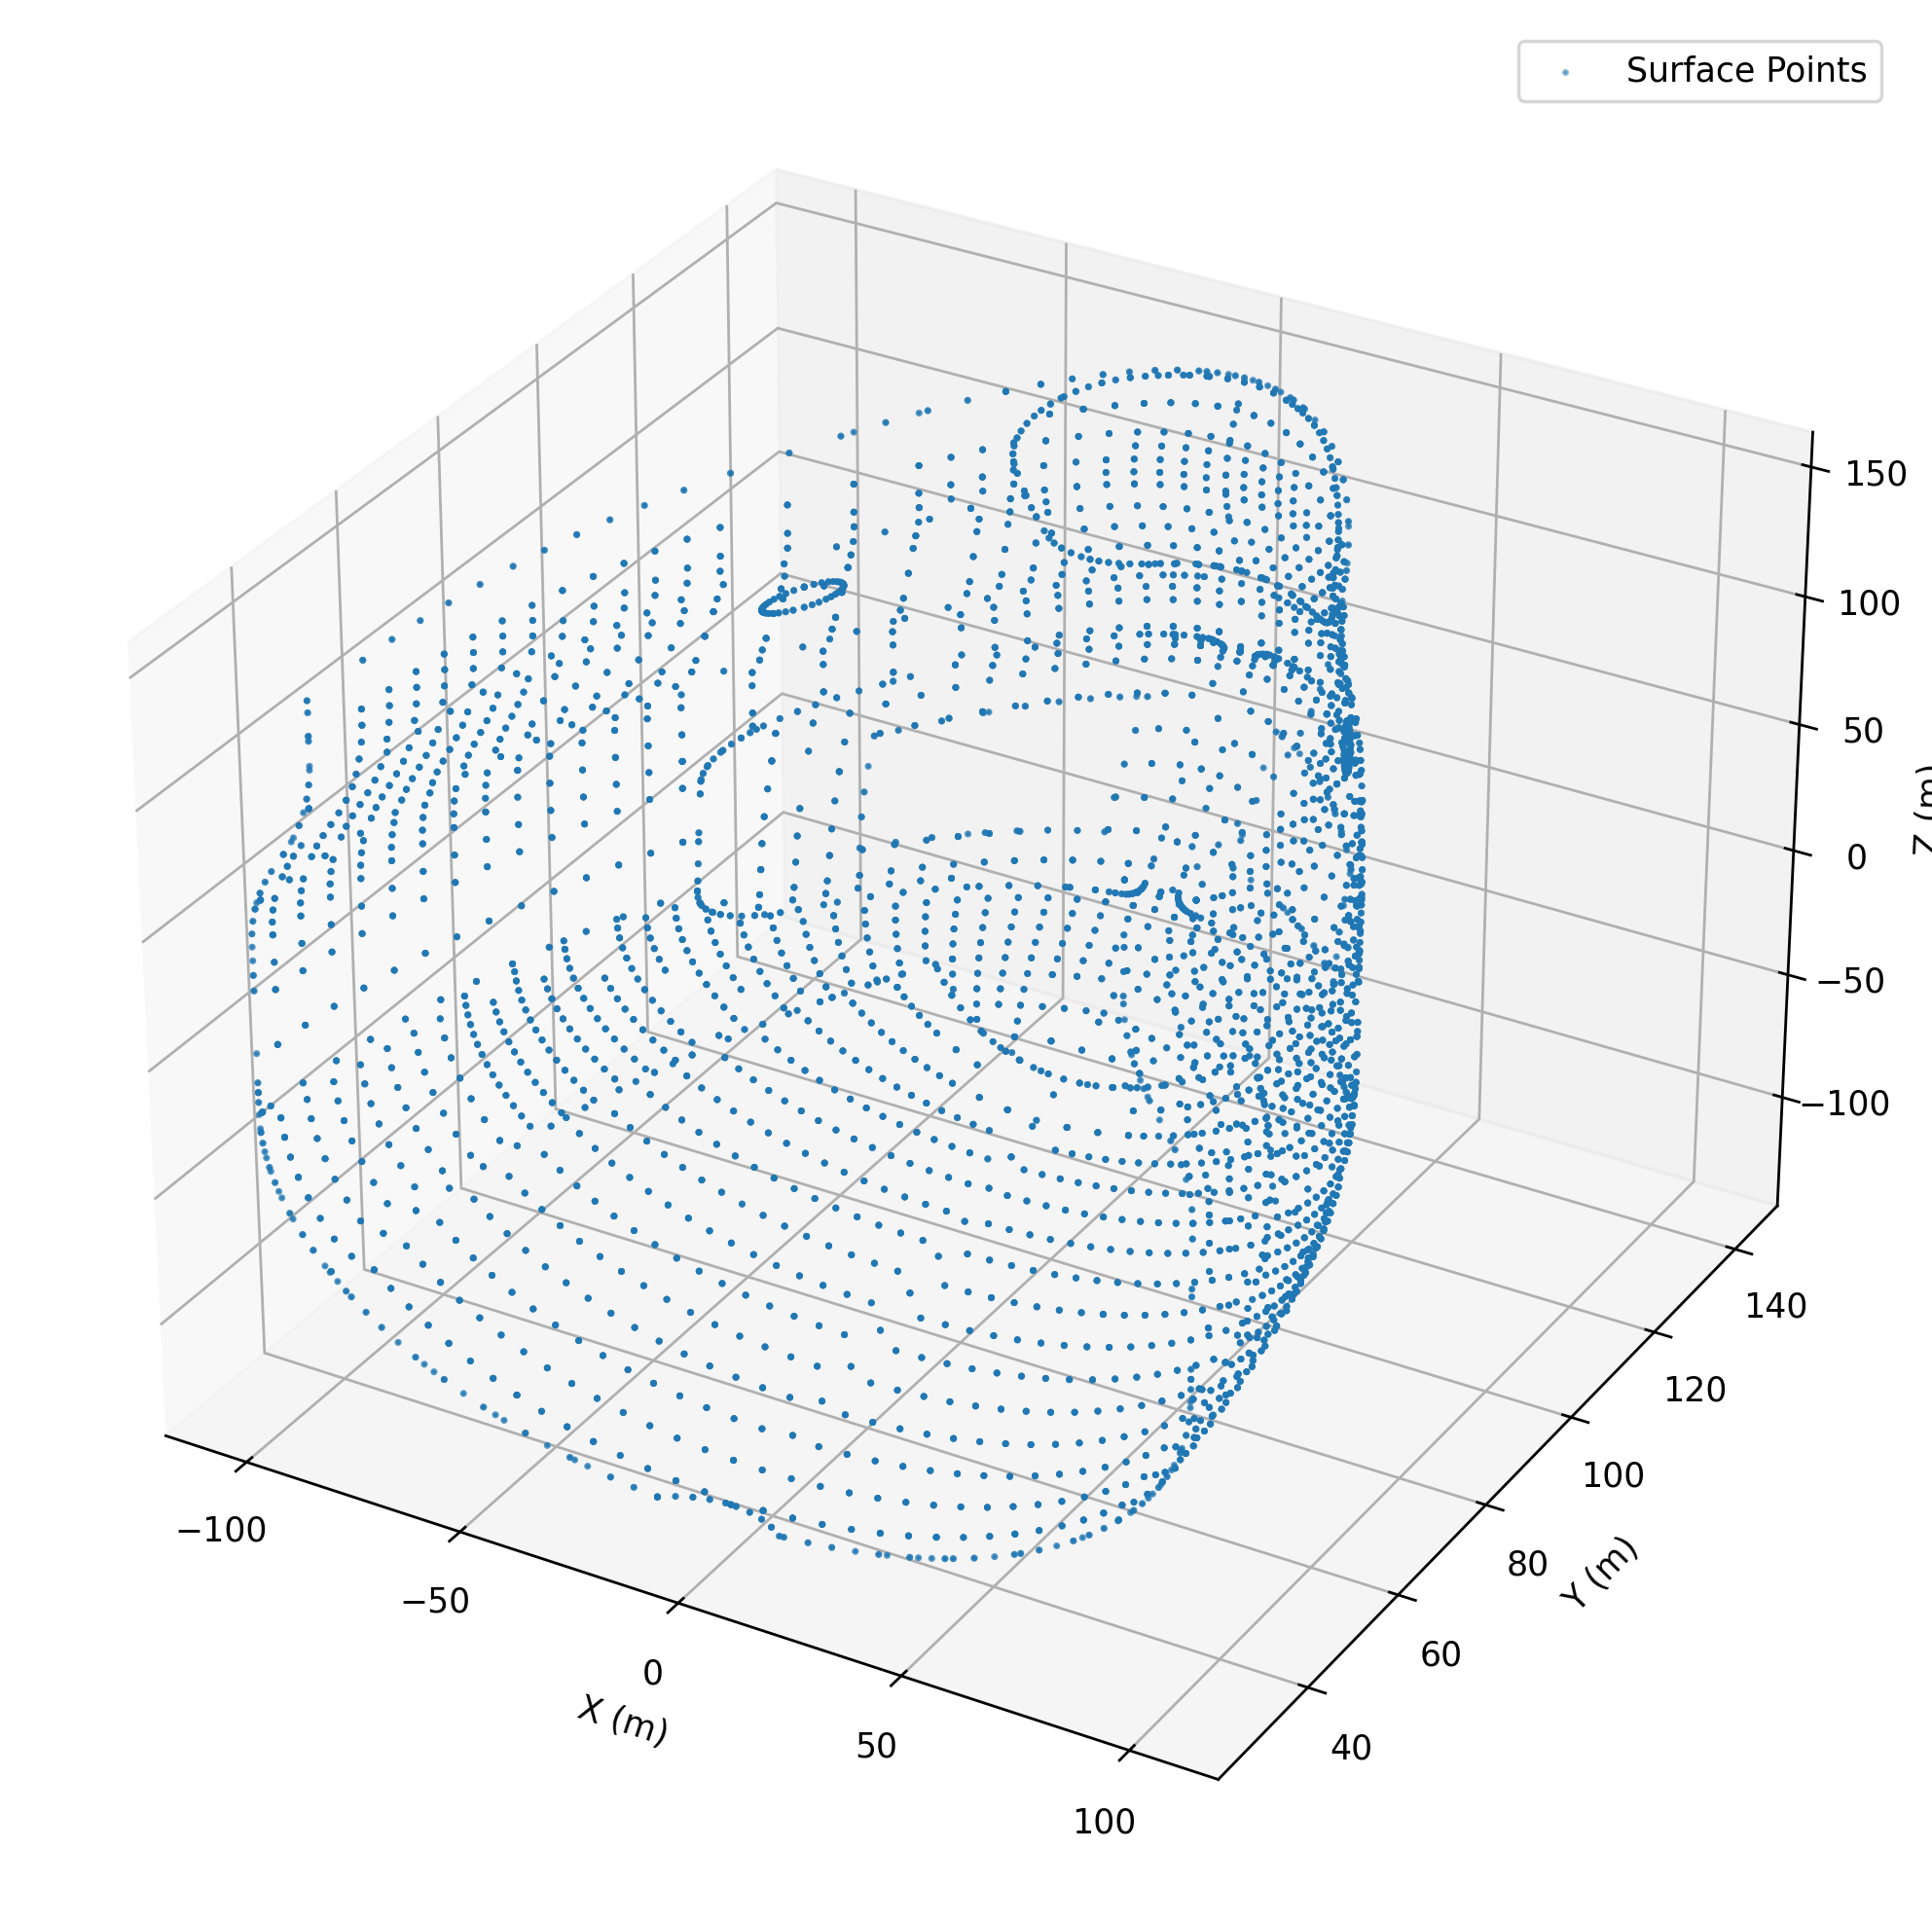

In [9]:
from stl import mesh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
stl_mesh = mesh.Mesh.from_file(r'./mesh/inner.STL')

# 提取顶点坐标
vertices = stl_mesh.vectors.reshape(-1, 3)  # 每个三角形有三个顶点，合并成一维数组

# 计算法线向量
def compute_normal(v1, v2, v3):
    """计算由三个顶点构成的三角形的法向量"""
    u = v2 - v1
    v = v3 - v1
    return np.cross(u, v)


# 创建一个3D绘图
fig = plt.figure(dpi=250, figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# 绘制表面点
ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], s=1, marker='o', alpha=0.5, label="Surface Points")
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.legend()

plt.show()

(16173, 3)
(48782,)


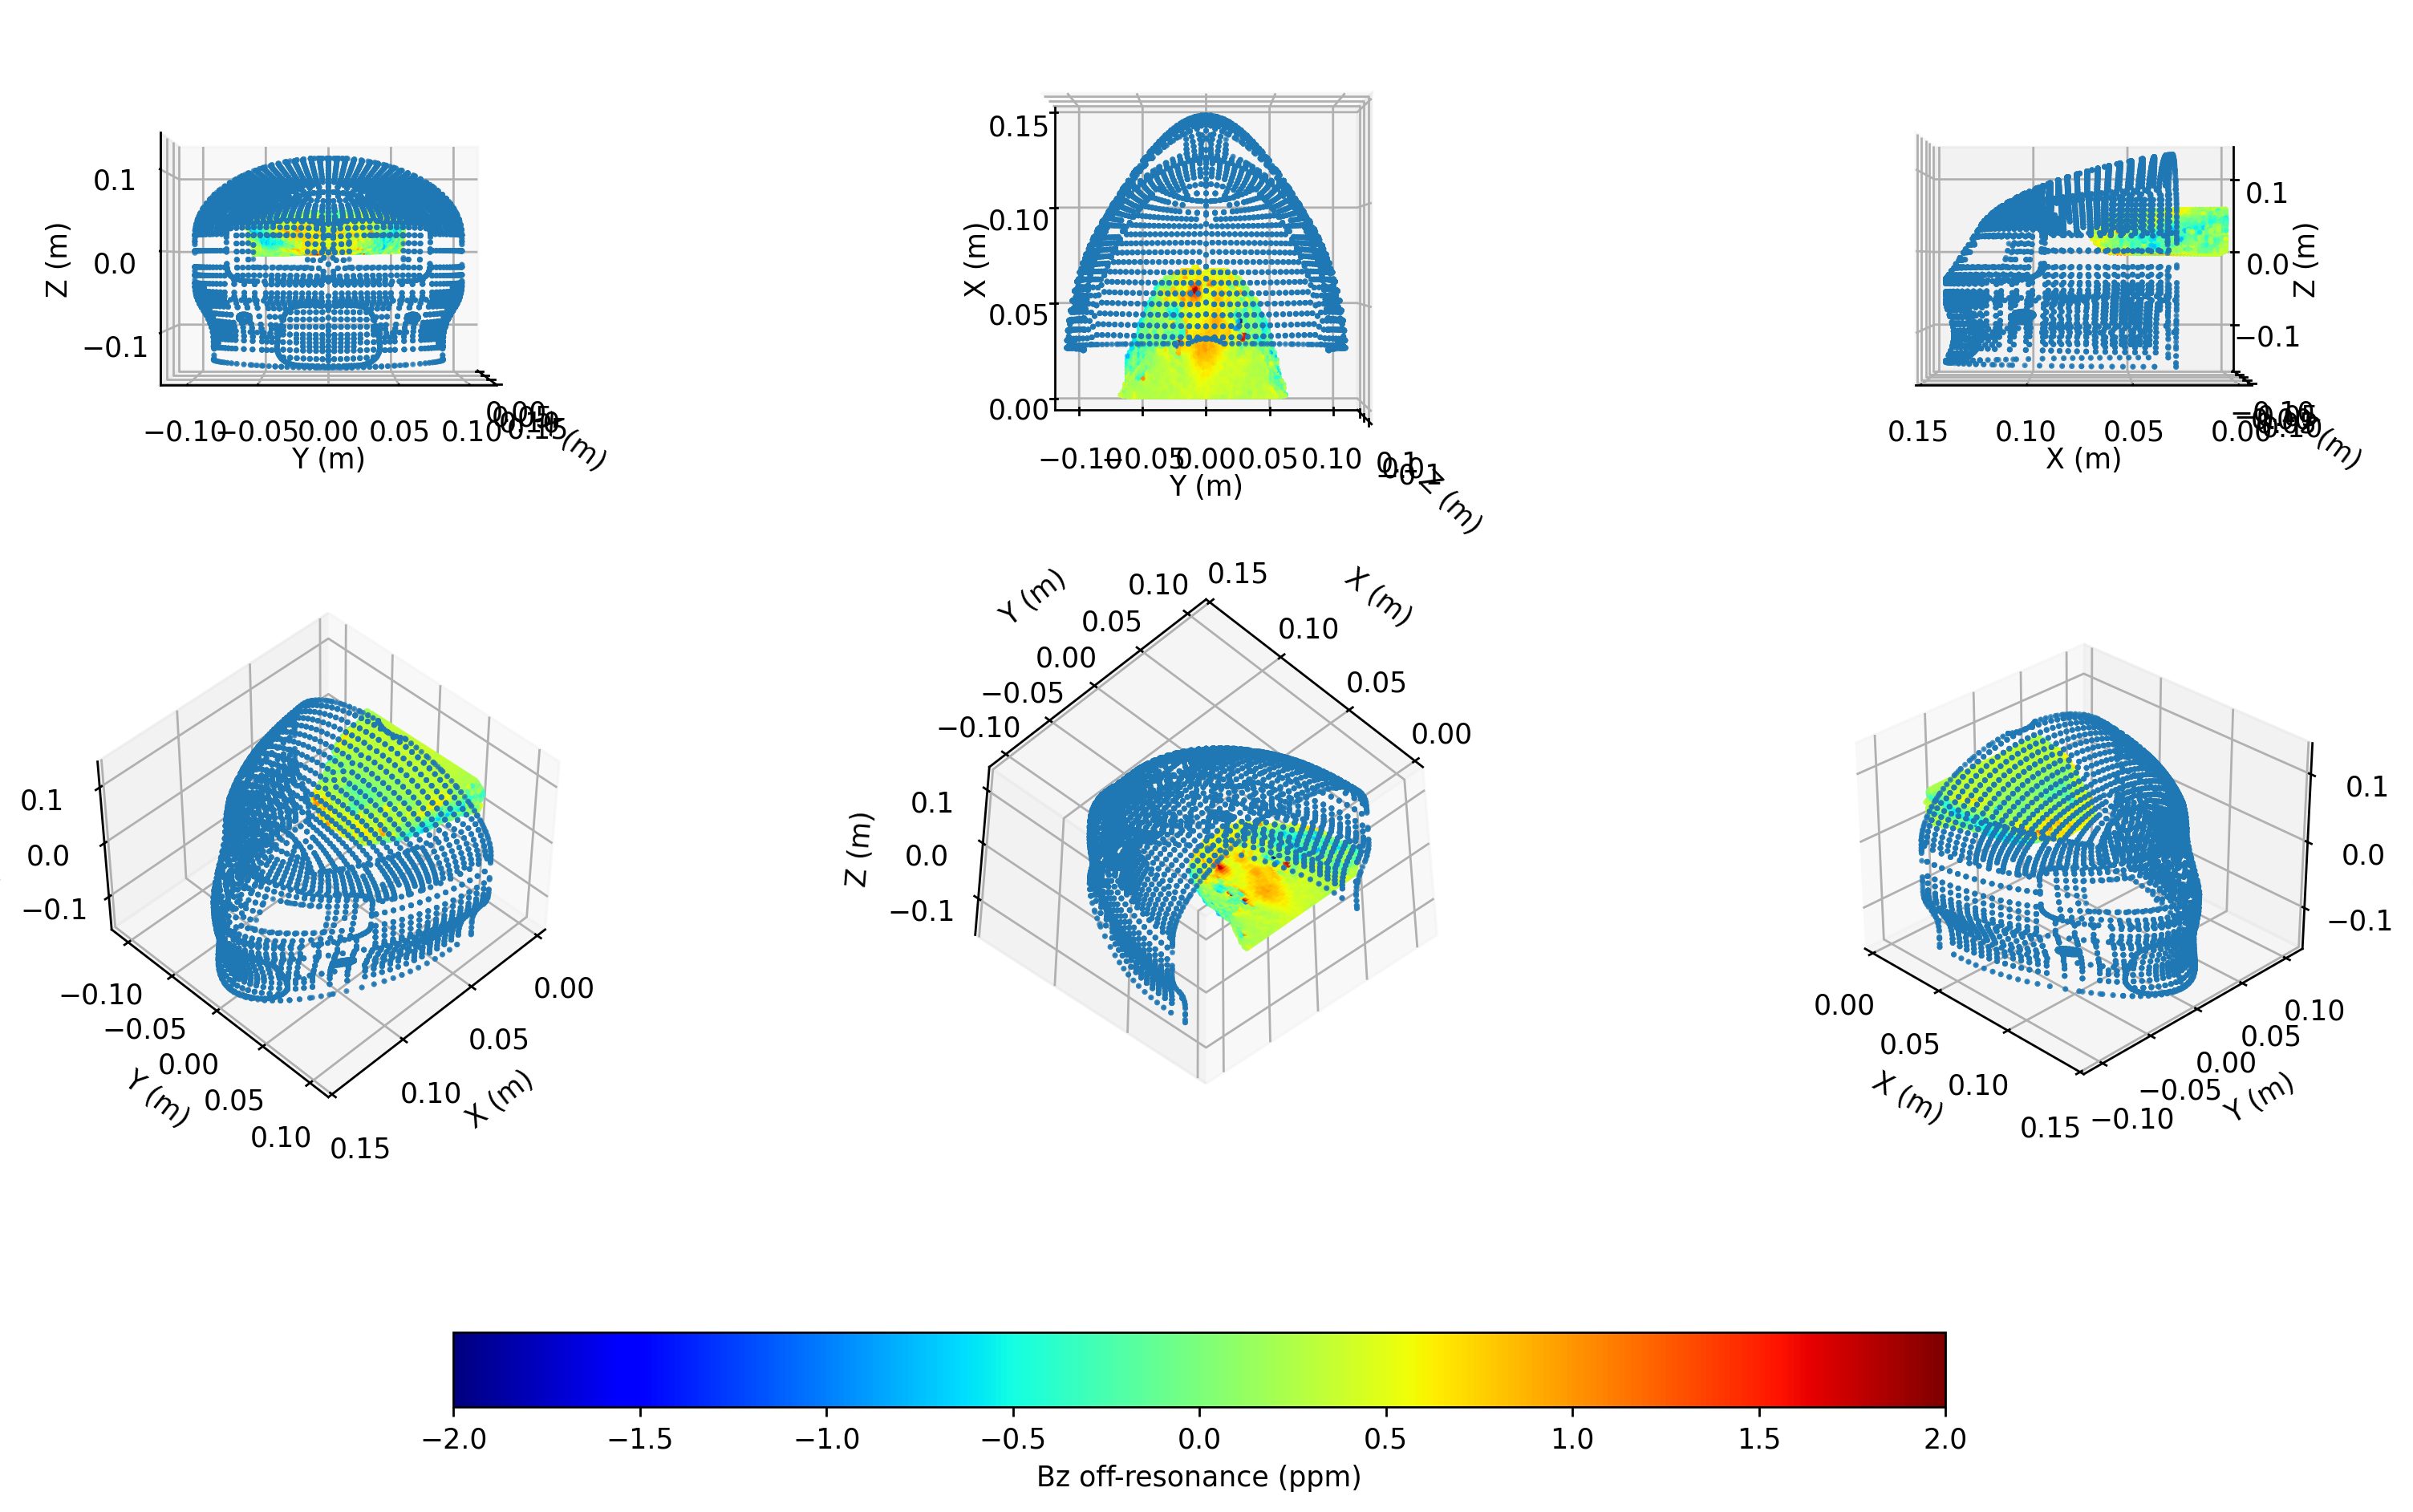

In [11]:
from scipy.linalg import lstsq
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
import matplotlib as mpl
import pandas as pd
a = 0.14
L = 0.3
h_phi = 0.004  # 方位角步长
h_z = 0.004   # 高度步长
mu_0 = 4 * np.pi * 1e-7
N_phi = int(2 * np.pi * a / h_phi)  # 方位角方向的网格数量
Nz = int(L / h_z)  # 高度方向的网格数量
N = N_phi * Nz


# 读取 Excel 文件
# file_path = r"./coords.xlsx"
# df = pd.read_excel(file_path)

# # 提取 X, Y, Z 坐标并进行单位转换 (假设单位是毫米，转换为米)
# x_coords = df['X'].values / 1000
# y_coords = df['Y'].values / 1000
# z_coords = df['Z'].values / 1000
x_coords = vertices[:,0] / 1000
y_coords = vertices[:,1] / 1000
z_coords = vertices[:,2] / 1000
grid_points = []
# x_symmetry = x_coords  
# y_symmetry = -y_coords + 0.08
# z_symmetry = z_coords 
# x_coords = np.concatenate([x_coords, x_symmetry]) 
# y_coords = np.concatenate([y_coords, y_symmetry]) - 0.04
# z_coords = np.concatenate([z_coords, z_symmetry]) - 0.03

# x_coords = -x_coords
# z_coords = -z_coords
rotation_matrix = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, -1]
])
grid_points = np.column_stack((x_coords, y_coords, z_coords))
grid_points = grid_points @ rotation_matrix.T
# # 生成源点的网格点坐标
# grid_points = []
# for n in range(1, N_phi * Nz + 1):
#     # 计算 alpha 和 beta
#     alpha = (n - 1) % N_phi
#     beta = (n - alpha - 1) // N_phi + 1
    
#     # 计算源点坐标
#     x_n = a * np.cos(alpha * h_phi / a)
#     y_n = a * np.sin(alpha * h_phi / a)
#     z_n = -L / 2 + (2 * beta - 1) / 2 * h_z
    
#     # 将坐标添加到网格点列表
#     grid_points.append((x_n, y_n, z_n))

# # 转换为 numpy 数组
# grid_points = np.array(grid_points) 
# # 获取圆柱表面上网格点的坐标
x_coords = grid_points[:, 0]
y_coords = grid_points[:, 1]
z_coords = grid_points[:, 2]
print(grid_points.shape)
# 假设目标磁场 b_k (ΔB0)，从你的 fieldmap 中提取目标磁场数据
# 假设 b_target 是一个包含目标点坐标和磁场强度的3D fieldmap
# n = 1
B0_map = sio.loadmat("B0_map_valid_sf.mat")
a = 0.1
b_k = B0_map['B0_data'].flatten() * 5 / 1e6
print(b_k.shape)
x_k = B0_map['X'].flatten()
y_k = B0_map['Y'].flatten()
z_k = B0_map['Z'].flatten()
# x_k = x_k[::n]
# y_k = y_k[::n]
# z_k = z_k[::n]
# b_k = b_k[::n] * 5 / 1e6 
fig = plt.figure(dpi=250, figsize=(16, 10))
for idx, (elev, azim) in enumerate([(0, 0), (-90, 0), (0, 90), (45, 45), (-45, 45), (30, -45)]):
    ax = fig.add_subplot(2, 3, idx + 1, projection='3d')
    # 绘制电流源网格点
    ax.scatter(x_coords, y_coords, z_coords, s=1, marker='o', alpha=0.5, label="Current Sources")
    # 绘制目标磁场点并设置颜色
    ax.scatter(x_k, y_k, z_k,s=1, c=b_k, cmap='jet', marker='o', alpha=0.8, label="Target B Field")
    ax.view_init(elev=elev, azim=azim) 
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-2, vmax=2), cmap='jet'),
             ax=fig.axes, orientation='horizontal', label='Bz off-resonance (ppm)', shrink=0.6)

In [12]:
# 计算 r+ 和 r- 的函数
def compute_r_plus_minus(x_k, y_k, z_k, x_n, y_n, z_n, h_z):
    """计算r_+ 和 r_-"""
    r_plus = np.sqrt((x_k - x_n)**2 + (y_k - y_n)**2 + (z_k - (z_n + h_z / 2))**2)
    r_minus = np.sqrt((x_k - x_n)**2 + (y_k - y_n)**2 + (z_k - (z_n - h_z / 2))**2)
    return r_plus, r_minus

# 计算 c_{k,n} 的函数
def compute_c_k_n(x_k, y_k, z_k, x_n, y_n, z_n, h_phi, h_z, a):
    """计算c_{k,n}的值"""
    r_plus, r_minus = compute_r_plus_minus(x_k, y_k, z_k, x_n, y_n, z_n, h_z)
    c_k_n = (mu_0 / (4 * np.pi * a)) * (x_n * x_k + y_n * y_k - a**2) * (1 / r_minus**3 - 1 / r_plus**3) * h_phi
    return c_k_n

# 计算目标磁场的总和
def compute_field_matrix(x_k, y_k, z_k, grid_points, N, h_phi, h_z, a):
    """计算磁场矩阵C"""
    C = np.zeros((x_k.size, len(grid_points)))
    for i in range(x_k.size):
        for n in range(len(grid_points)):
            x_n, y_n, z_n = grid_points[n]
            C[i, n] = compute_c_k_n(x_k[i], y_k[i], z_k[i], x_n, y_n, z_n, h_phi, h_z, a)
    return C
C = compute_field_matrix(x_k.flatten(), y_k.flatten(), z_k.flatten(), grid_points, len(grid_points), h_phi, h_z, a)
# N = len(grid_points)  # 电流源的数量
# psi_n = np.ones(len(grid_points)) 

# def error_function(psi_n, C, b_k):
#     """计算目标场与计算场之间的二次误差"""
#     b_computed = np.dot(C, psi_n)  # 计算磁场
#     error = np.linalg.norm(b_k - b_computed)**2  # 计算二次误差
#     return error
# # 使用最小化函数优化电流强度 psi_n
# result = minimize(error_function, psi_n, args=(C, b_k), 
#                   method='L-BFGS-B', options={'disp': True, 'maxiter': 100})

# # 优化后的电流强度
# optimized_psi_n = result.x
# print(optimized_psi_n)

psi_n, _, _, _ = lstsq(C, b_k)

总点数: 2821
总面数: 5391
边界点数: 253


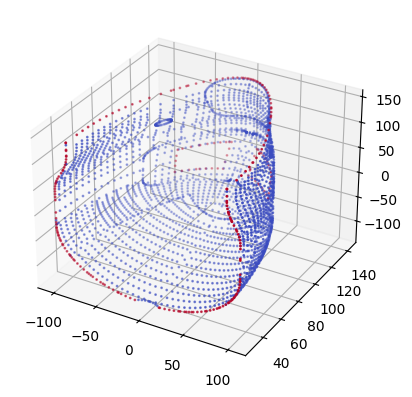

总耗时： 0.10440707206726074 秒


In [40]:
import time
import numpy as np
from stl import mesh
import matplotlib.pyplot as plt

time_start = time.time()

filename = "inner.STL"  # 换成你的文件名

# 用 numpy-stl 读取 STL 文件
your_mesh = mesh.Mesh.from_file(filename)

# STL 文件的三角面，每个面是3个顶点
# your_mesh.vectors.shape = (num_faces, 3, 3)

# 取出所有点
points = your_mesh.vectors.reshape(-1, 3)

# 去重，得到真正的点集合
unique_points, inverse_indices = np.unique(points, axis=0, return_inverse=True)

# 重新映射三角面索引
faces = inverse_indices.reshape(-1, 3)

print("总点数:", unique_points.shape[0])
print("总面数:", faces.shape[0])

# 建立边列表
edges = []
edge_count = {}

for face in faces:
    for i in range(3):
        v1 = face[i]
        v2 = face[(i + 1) % 3]
        edge = tuple(sorted((v1, v2)))
        edges.append(edge)
        edge_count[edge] = edge_count.get(edge, 0) + 1

# 边界边（只出现过1次的边）
boundary_edges = [edge for edge, count in edge_count.items() if count == 1]

# 标记每个点是不是边界点
boundary_point_flags = np.zeros(unique_points.shape[0], dtype=int)
for edge in boundary_edges:
    boundary_point_flags[edge[0]] = 1
    boundary_point_flags[edge[1]] = 1

print("边界点数:", np.sum(boundary_point_flags))

# 可视化一下
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(unique_points[:, 0], unique_points[:, 1], unique_points[:, 2], s=1, c=boundary_point_flags, cmap='coolwarm')
plt.show()

time_end = time.time()
print('总耗时：', time_end - time_start, '秒')


In [ ]:
import numpy as np
from scipy.sparse import lil_matrix

# 假设 boundary_edges 和 unique_points 是已定义的
boundary_indices = np.unique(np.array(boundary_edges).flatten())
boundary_points = unique_points[boundary_indices]

N = grid_points.shape[0]
N_boundary = boundary_points.shape[0]
Gamma = np.zeros((N, N_boundary))

# 映射边界点到 `Gamma` 矩阵
for i, idx in enumerate(boundary_indices):
    Gamma[idx, i] = 1

num_points = grid_points.shape[0]

# 使用稀疏矩阵表示 A
A = lil_matrix((num_points, num_points))

# 根据 faces 更新邻接矩阵
for face in faces:
    for i in range(3):
        v1 = face[i]
        v2 = face[(i + 1) % 3]
        A[v1, v2] = -1
        A[v2, v1] = -1

# 更新对角线元素
for i in range(num_points):
    A[i, i] = -A[i].sum()

# 电导率和厚度
kappa = 5.96e7  # 电导率
t = 1.4e-3      # 厚度

# 乘以系数，得到 R
R = (2 / (kappa * t)) * A

# 打印稀疏矩阵的稠密表示
print(A.toarray())


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [142]:
def optimize_phi_lambda(Gamma, R, b, C, lambda_reg):
    """
    计算优化后的 ψ(λ)
    :param Gamma: 约束矩阵 Gamma (N × N')
    :param R: 正则化矩阵 R (N' × N')
    :param C: 线性算子矩阵 C (M × N)
    :param b: 目标场 b (M × 1)
    :param lambda_reg: 正则化参数 λ
    :return: 计算得到的 ψ(λ)
    """

    # 计算 D = [Γ^T (λR + C^T C) Γ]^{-1}
    term = lambda_reg * R + C.T @ C
    c = Gamma.T @ C.T @ b
    
    # 计算 ψ(λ) = Γ D Γ^T C^T b
    A = Gamma.T @ term @ Gamma
    psi_prime = np.linalg.solve(A, c)
    psi_lambda = Gamma @ psi_prime

    return psi_lambda

In [143]:
psi_lambda = optimize_phi_lambda(Gamma, R, b_k, C,  1e-13)

LinAlgError: Singular matrix

In [124]:
sigma_w = 1
nominal_current_I = np.max(np.gradient(psi_lambda)) * sigma_w
print(nominal_current_I)

25.76773644587313


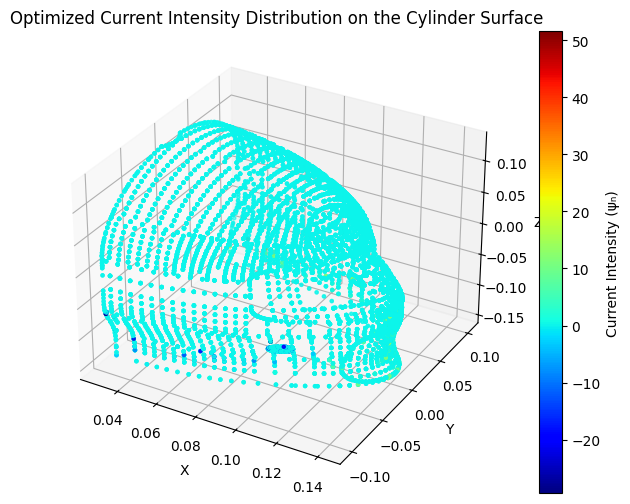

In [125]:
optimized_psi_n = psi_lambda
x_coords = grid_points[:, 0]
y_coords = grid_points[:, 1]
z_coords = grid_points[:, 2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x_coords, y_coords, z_coords, c=optimized_psi_n, s=5, marker='o', cmap='jet')

ax.set_title("Optimized Current Intensity Distribution on the Cylinder Surface")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

fig.colorbar(sc, label="Current Intensity (ψₙ)")

plt.show()

In [89]:
eta = 100 * (1 - np.std(b_k-C @ optimized_psi_n.squeeze()) / np.std(b_k))
print(eta)

2.4185716344725994


In [77]:
import numpy as np

# 保存 psi_lambda
np.save("psi_lambda_spe_inner.npy", optimized_psi_n)
psi_lambda = np.load("psi_lambda_spe_inner.npy")

In [ ]:
import plotly.graph_objects as go
from scipy.spatial import Delaunay

x = grid_points[:, 0]
y = grid_points[:, 1]
z = grid_points[:, 2]
values = optimized_psi_n 

fig = go.Figure()

fig.add_trace(go.Mesh3d(
    x=x, y=y, z=z,
    i=x,
    j=y,
    k=z,
    intensity=values,
    colorscale='jet',
    opacity=0.8
))

fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=values,
        colorscale='jet',
        opacity=0.8
    )
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title="3D Contour on Irregular Surface (Interactive)")

fig.show()


5.3396568827734585 3.259073810043344
-1.1489765064842492 0.10040154285359493


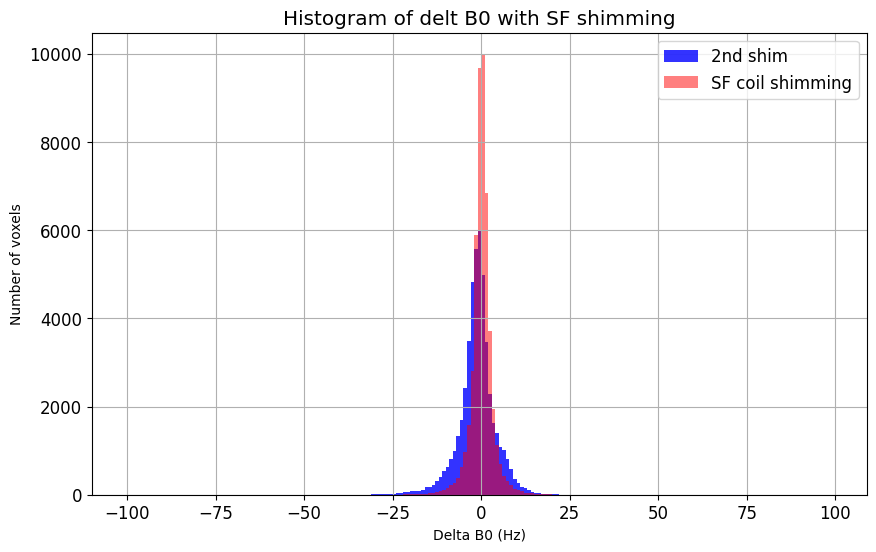

In [ ]:
unshimmed_data = b_k / 5 * 1e6 * 42.58
unshimmed_data_nan = np.where(unshimmed_data == 0, np.nan, unshimmed_data)
unshimmed_values = unshimmed_data_nan[~np.isnan(unshimmed_data_nan)] 


shimmed_data = C@optimized_psi_n / 5 * 1e6 * 42.58
shimmed_data_nan = np.where(shimmed_data == 0, np.nan, shimmed_data)
shimmed_values = shimmed_data_nan[~np.isnan(shimmed_data_nan)]
shimmed_values = unshimmed_values - shimmed_values
print(np.std(unshimmed_values), np.std(shimmed_values))
print(np.mean(unshimmed_values), np.mean(shimmed_values))
plt.figure(figsize=(10, 6),dpi = 100)
plt.hist(unshimmed_values.flatten(), bins=np.arange(-100, 100, 1), color='blue', alpha=0.8, label='2nd shim')
plt.hist(shimmed_values.flatten(), bins=np.arange(-100, 100, 1), color='red', alpha=0.5, label='SF coil shimming')
# plt.hist(values_coil_shimming.flatten(), bins=np.arange(-2, 2.05, 0.02), color='red', alpha=0.4, label='coil_shimming')
plt.rcParams.update({'font.size': 12})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Histogram of delt B0 with SF shimming')
plt.xlabel('Delta B0 (Hz)')
plt.ylabel('Number of voxels')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
print(grid_points.shape)
print(b_k.shape)


(1709, 3)
(48782,)
